## Importing libraries

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from PIL import Image
import glob
import matplotlib.pyplot as plt
from skimage.color import rgb2hed,rgba2rgb,rgb2gray
from skimage.io import imread
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,accuracy_score
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import statsmodels.api as sm
import torch
from torch import nn
import torchvision.models as models
from torch.optim import Adam
import seaborn as sns
import numpy as np
import warnings
import os

## Download and load expression data into a dataframe



In [ ]:

protein_ex = pd.read_csv('protein_expression_data.csv')

protein_ex['specimen_id']=protein_ex.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
protein_ex['image_id']=protein_ex.VisSpot.apply(lambda x: x.split('-')[2])+'_'+protein_ex.id #create image id field
protein_ex.set_index('image_id', inplace=True, drop=False)
protein_ex.sort_index(inplace=True)
# protein_ex = protein_ex.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']
print(protein_ex)


          Unnamed: 0                VisSpot  Location_Center_Y  \
image_id                                                         
A1_0x40          412  AAGTAAGCTTCCAAAC-1-A1         764.003658   
A1_0x42         7325  GTTTGAGCGGTTATGT-1-A1         799.511111   
A1_0x44         8102  TCACTCAGCGCATTAG-1-A1         832.902467   
A1_0x46         7085  GTGCGCTTACAAATGA-1-A1         858.343544   
A1_0x48         3748  CGAAGACTGCCCGGGA-1-A1         892.179831   
...              ...                    ...                ...   
D1_9x63         3609  CCTCCCGACAATCCCT-1-D1         123.760525   
D1_9x65          172  AACACGACTGTACTGA-1-D1          29.281573   
D1_9x67         2686  CACCGCCGACCAGCGA-1-D1         938.403662   
D1_9x69         2813  CAGAGTGATTTAACGT-1-D1         844.093656   
D1_9x71         6877  GTCAGTTGTGCTCGTT-1-D1         740.107483   

          Location_Center_X      SMAa     CD11b      CD44      CD31      CDK4  \
image_id                                                    

In [ ]:
protein_ex['Specimen'] = protein_ex['VisSpot'].apply(lambda x: x.split('-')[2])

# Filtering for specimens A1, B1, and D1
filtered_data = protein_ex[protein_ex['Specimen'].isin(['A1', 'B1', 'D1'])]

# Counting the number of spots in each of the specified specimens
spots_count = filtered_data['Specimen'].value_counts()

print("Number of examples or spots in each specimen:",spots_count)

Number of examples or spots in each specimen: A1    2894
D1    1753
B1    1145
Name: Specimen, dtype: int64


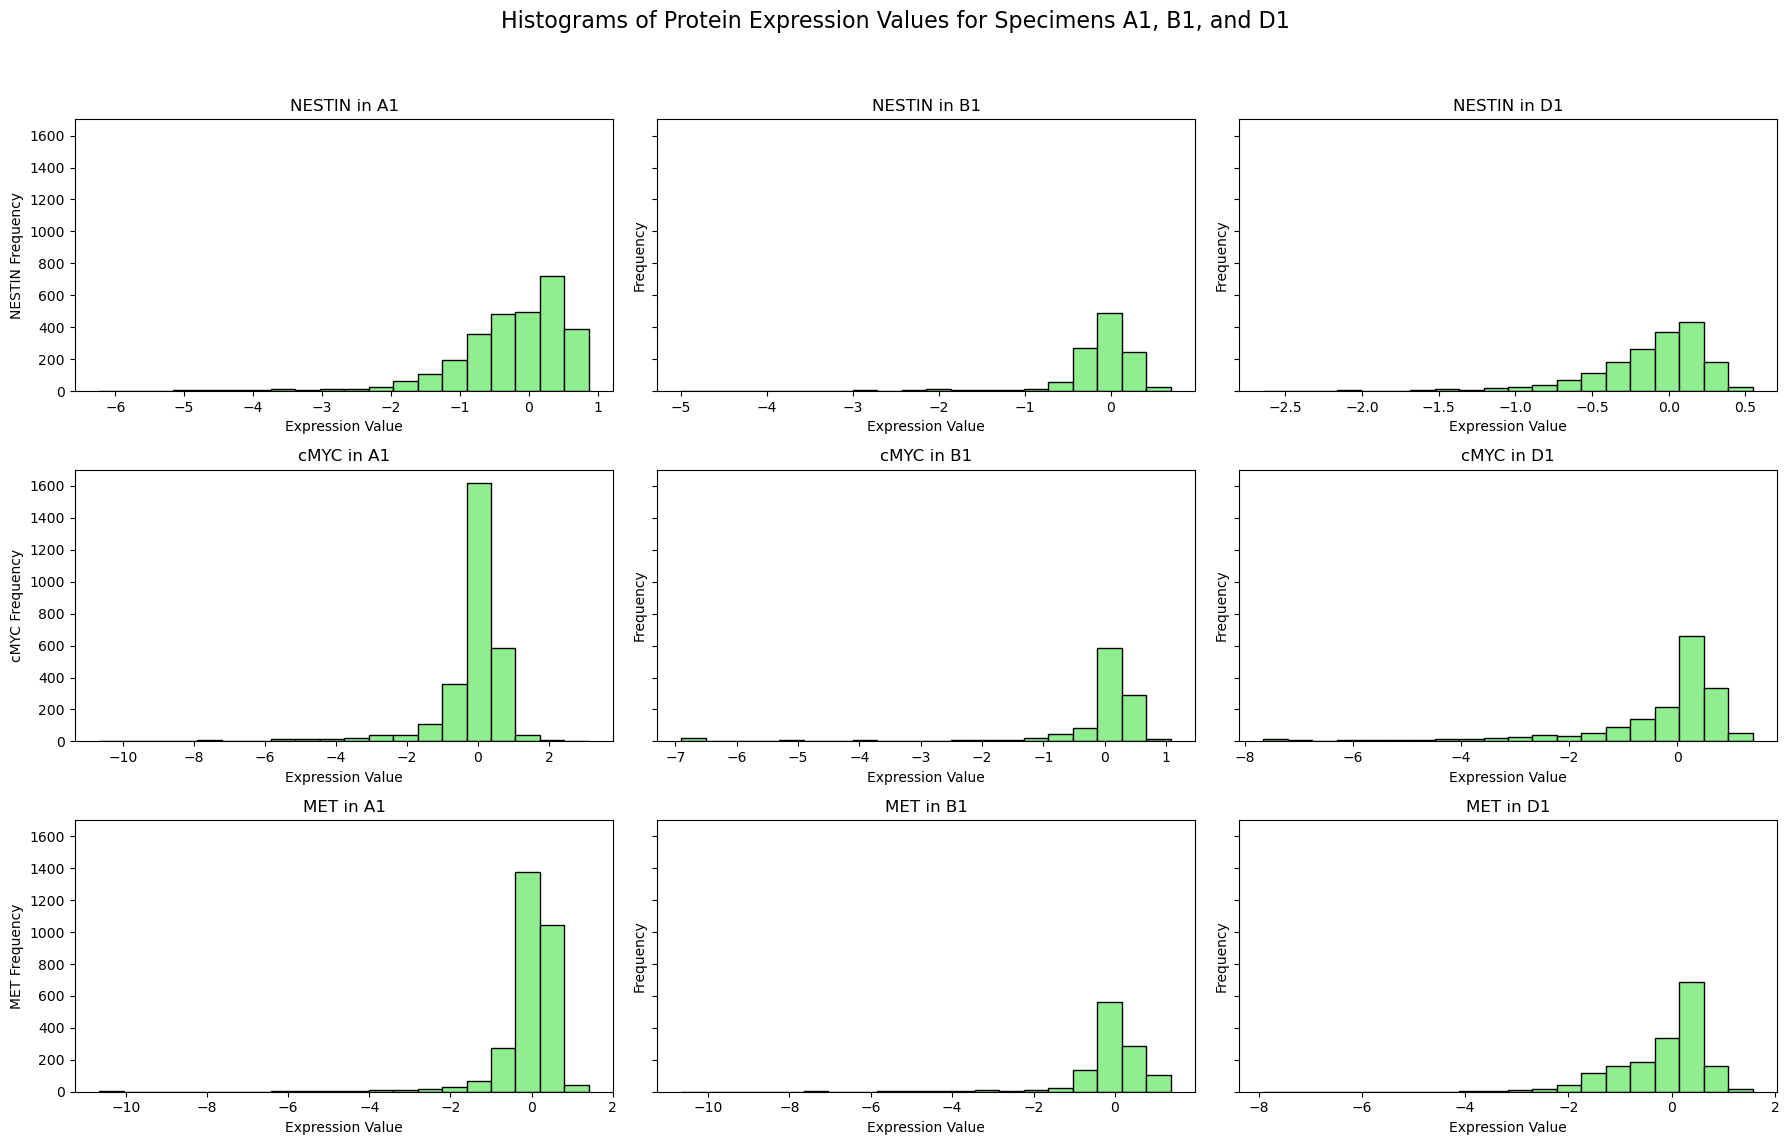

In [ ]:


# Filter data for each specified protein for each specimen
proteins = ['NESTIN', 'cMYC', 'MET']

# Creating a figure for the histograms
fig, axs = plt.subplots(len(proteins), 3, figsize=(18, 12), sharey=True)
fig.suptitle('Histograms of Protein Expression Values for Specimens A1, B1, and D1', fontsize=16)

# Specimens list for iteration
specimens = ['A1', 'B1', 'D1']

# Generating histograms
for i, protein in enumerate(proteins):
    for j, specimen in enumerate(specimens):
        axs[i, j].hist(filtered_data[filtered_data['Specimen'] == specimen][protein], bins=20, color='lightgreen', edgecolor='black')
        axs[i, j].set_title(f'{protein} in {specimen}')
        axs[i, j].set_xlabel('Expression Value')
        axs[i, j].set_ylabel('Frequency')
        if j == 0:
            axs[i, j].set_ylabel(f'{protein} Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Processing D1_62x84.png:


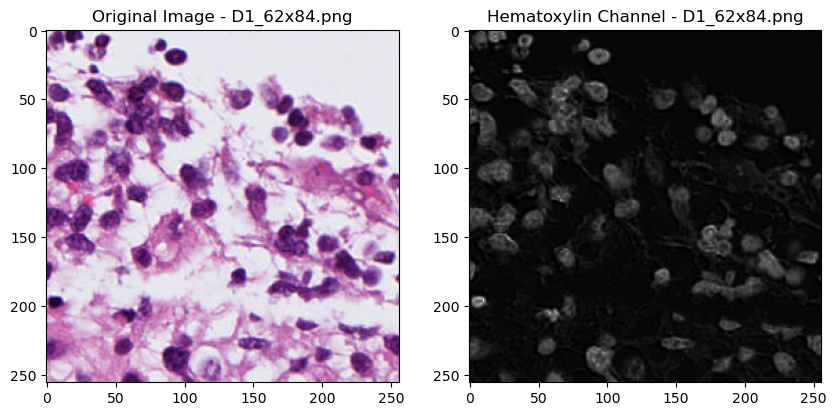

Processing A1_1x41.png:


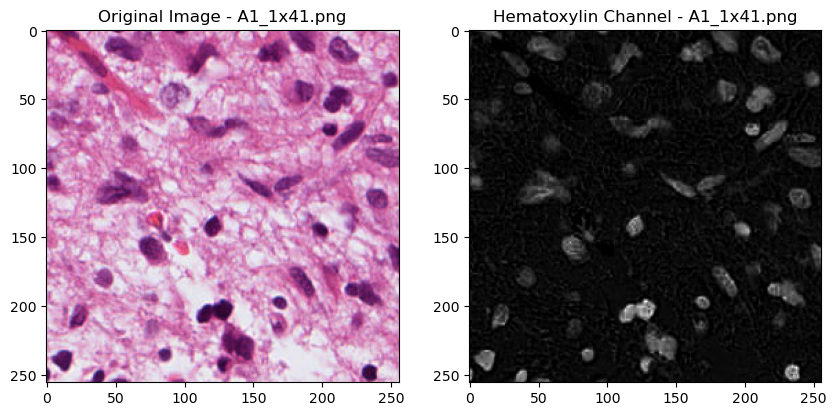

Processing B1_10x84.png:


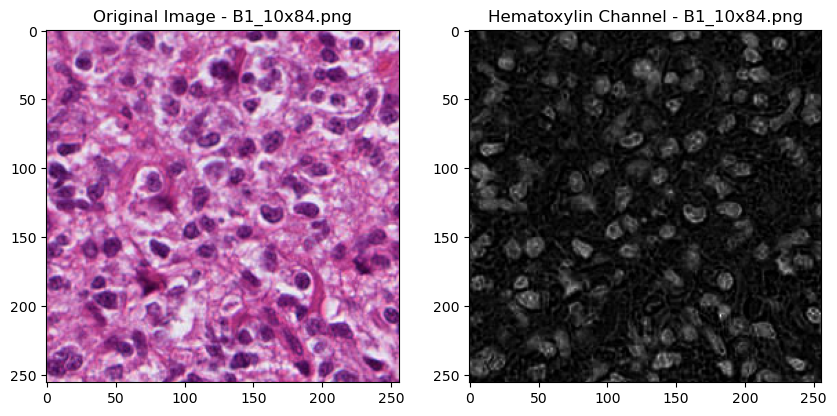

Processing D1_35x53.png:


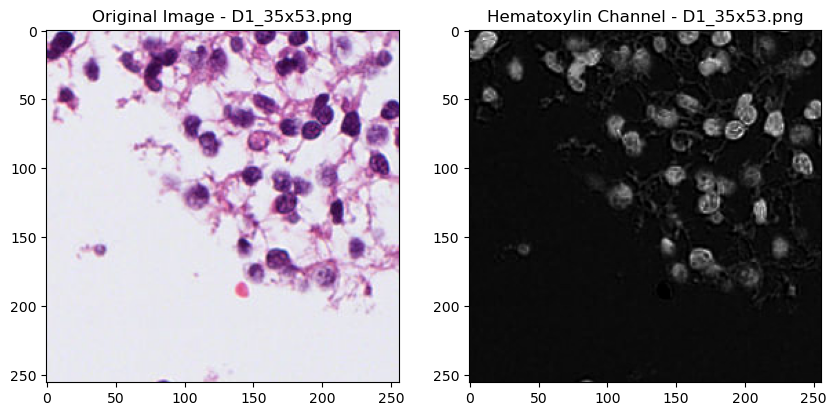

Processing A1_26x40.png:


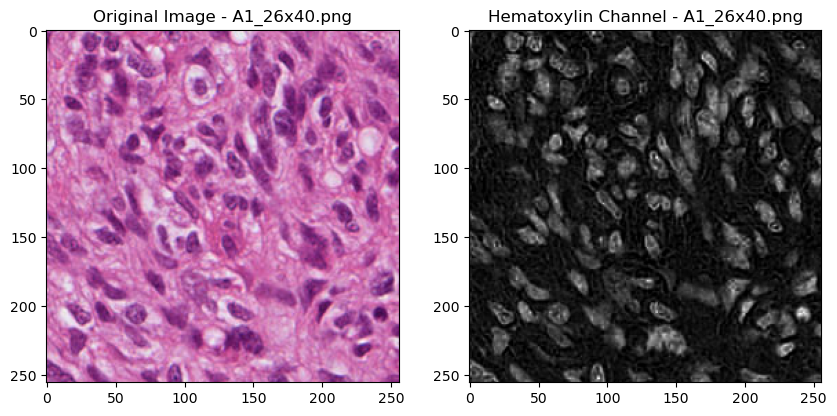

In [ ]:

import random
from glob import glob


image_dir = 'patches_256/'
image_files = [f for f in glob(os.path.join(image_dir, '*.png')) if any(specimen in f for specimen in ['A1', 'B1', 'D1'])]

# Randomly select 5 images
selected_images = random.sample(image_files, 5)

for image_path in selected_images:
    # Extract the file name from the image path
    file_name = os.path.basename(image_path)

    # Read the image
    image = imread(image_path)

    # Convert RGBA to RGB if necessary
    if image.shape[2] == 4:
        image = rgba2rgb(image)

    # Convert the image to HED color space
    image_hed = rgb2hed(image)

    # Print the file name
    print(f'Processing {file_name}:')

    # Visualize the original and Hematoxylin channel
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Original Image - {file_name}')

    plt.subplot(1, 2, 2)
    plt.imshow(image_hed[:, :, 0], cmap='gray')  # Hematoxylin channel
    plt.title(f'Hematoxylin Channel - {file_name}')

    plt.show()



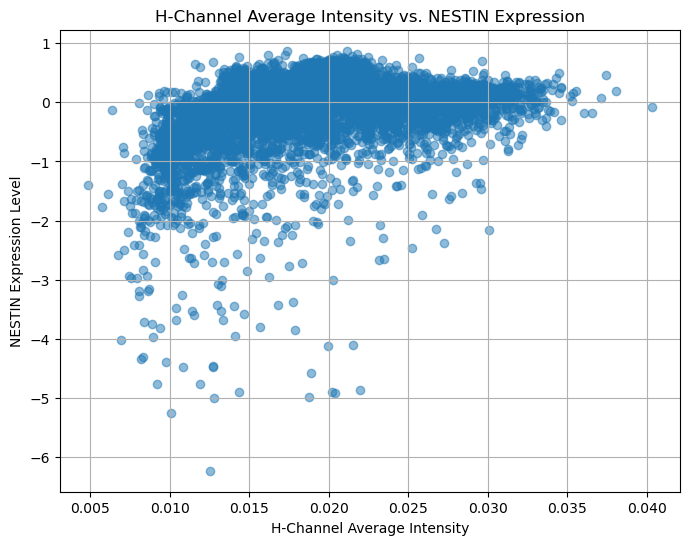

Correlation coefficient: 0.379616309866266


In [ ]:

# Filter the DataFrame for specimens A1, B1, and D1
df_filtered = protein_ex[protein_ex['specimen_id'].isin(['A1', 'B1', 'D1'])]

# Initialize lists to store H-channel averages and NESTIN expressions
h_channel_avgs = []
nestin_expressions = []

image_folder = 'patches_256/'

# Process images
for index, row in df_filtered.iterrows():
    image_path = os.path.join(image_folder, f"{row['specimen_id']}_{row['id']}.png")
    if os.path.exists(image_path):
        image = imread(image_path)
        if image.shape[-1] == 4:
            image = rgba2rgb(image)  # Convert RGBA to RGB
        image_hed = rgb2hed(image)
        h_avg = np.mean(image_hed[:, :, 0])  # H-channel average intensity
        h_channel_avgs.append(h_avg)
        nestin_expressions.append(row['NESTIN'])

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(h_channel_avgs, nestin_expressions, alpha=0.5)
plt.title('H-Channel Average Intensity vs. NESTIN Expression')
plt.xlabel('H-Channel Average Intensity')
plt.ylabel('NESTIN Expression Level')
plt.grid(True)
plt.show()

# Calculate and print correlation
correlation = np.corrcoef(h_channel_avgs, nestin_expressions)[0, 1]
print(f'Correlation coefficient: {correlation}')


In [ ]:

# Ignore all warnings
warnings.filterwarnings('ignore')


image_folder = 'patches_256/'

# Initialize a DataFrame to store the features for each image
features_df = pd.DataFrame(columns=['filename', 'H_mean', 'H_variance', 'R_mean', 'R_variance', 'G_mean', 'G_variance', 'B_mean', 'B_variance'])

# List of specimen identifiers
specimens = ['A1', 'B1', 'D1']

# Process each image file in the directory
for filename in os.listdir(image_folder):
    if any(specimen in filename for specimen in specimens):  # Filter for specific specimens
        image_path = os.path.join(image_folder, filename)
        image = imread(image_path)

        # If the image has an alpha channel, convert from RGBA to RGB
        if image.shape[-1] == 4:
            image = rgba2rgb(image)

        # Convert the RGB image to HED color space
        image_hed = rgb2hed(image)

        # Extract the H channel and calculate its mean and variance
        H_channel = image_hed[:, :, 0]
        H_mean = np.mean(H_channel)
        H_variance = np.var(H_channel)

        # Calculate the mean and variance for the red, green, and blue channels
        R_channel = image[:, :, 0]
        G_channel = image[:, :, 1]
        B_channel = image[:, :, 2]
        R_mean = np.mean(R_channel)
        R_variance = np.var(R_channel)
        G_mean = np.mean(G_channel)
        G_variance = np.var(G_channel)
        B_mean = np.mean(B_channel)
        B_variance = np.var(B_channel)

        # Add the features to the DataFrame
        features_df = features_df.append({
            'filename': filename,
            'H_mean': H_mean,
            'H_variance': H_variance,
            'R_mean': R_mean,
            'R_variance': R_variance,
            'G_mean': G_mean,
            'G_variance': G_variance,
            'B_mean': B_mean,
            'B_variance': B_variance
        }, ignore_index=True)

# Display the DataFrame with the extracted features
print(features_df.head(20))


         filename    H_mean  H_variance      R_mean   R_variance      G_mean  \
0    B1_17x75.png  0.018292    0.000441    0.766811     0.018488    0.446921   
1    B1_24x92.png  0.011221    0.000087    0.883162     0.007786    0.832129   
2    D1_39x79.png  0.024228    0.000663  193.894150  1671.625804  136.516052   
3    D1_50x28.png  0.021536    0.000604  204.373657  1679.937193  172.251144   
4    A1_72x84.png  0.015723    0.000216    0.789609     0.011029    0.497950   
5    D1_49x63.png  0.022086    0.000584  201.747208  1659.622391  162.843124   
6    A1_59x53.png  0.011212    0.000193    0.800945     0.010210    0.447012   
7    D1_56x22.png  0.027876    0.000830  190.758423  2168.553762  145.954178   
8    A1_74x74.png  0.016326    0.000266    0.788817     0.013784    0.508816   
9    B1_13x69.png  0.013831    0.000270    0.851259     0.013973    0.738757   
10   A1_43x85.png  0.008392    0.000202    0.806835     0.013460    0.394388   
11   D1_65x67.png  0.031018    0.000950 

In [ ]:

image_directory = 'patches_256/'
images_processed = []
img_ids = []  # List to store image IDs
identifiers = ['A1', 'B1', 'D1']  # Identifiers to filter the images by

for filename in os.listdir(image_directory):
    # Check if the file ends with .png and contains any of the specified identifiers
    if filename.endswith('.png') and any(identifier in filename for identifier in identifiers):
        image_path = os.path.join(image_directory, filename)
        image = imread(image_path)
        if image.shape[2] == 4:  # Convert RGBA to RGB
            image = rgba2rgb(image)
        # Resize image to a smaller resolution, e.g., (50, 50)
        image_resized = resize(image, (50, 50), anti_aliasing=True)
        image_gray = rgb2gray(image_resized)  # Convert to grayscale
        image_flattened = image_gray.flatten()  # Flatten the grayscale image
        images_processed.append(image_flattened)

        # Extract or construct image_id from filename
        image_id = filename.split('.')[0]  # Adjust based on actual filename structure
        img_ids.append(image_id)

# Convert the list of processed images into a NumPy array
X = np.array(images_processed)

# Initialize PCA, specifying the desired amount of variance to be preserved
pca = PCA(n_components=0.95)

# Apply PCA transformation
X_pca = pca.fit_transform(X)

# Create a DataFrame to combine PCA features with image IDs
df_pca = pd.DataFrame(X_pca)
df_pca['image_id'] = img_ids  # Add image IDs as a column

# Display the first few rows of the DataFrame to verify
print(df_pca.head())

# Print the shape of the original data and the PCA-transformed data for comparison
print("Original shape:", X.shape)
print("Transformed shape:", X_pca.shape)

# Print the explained variance ratio of each principal component to understand the distribution
print("Explained variance ratio:", pca.explained_variance_ratio_)



           0         1         2         3         4         5         6  \
0  -1.921397 -0.114935 -0.056670  0.295918  0.304976 -0.069310  0.222266   
1  13.965051  4.078786  1.997243  3.883197 -0.777355  1.438952  2.979814   
2   1.356294  0.225692  0.922459  0.135064  0.040502 -0.135690 -0.228580   
3   7.062223 -2.143820  0.084525  1.070868  1.331040  0.036303  0.040779   
4   0.280762 -0.453223 -0.240409  1.047161 -0.031200  0.214955 -0.050450   

          7         8         9  ...       855       856       857       858  \
0  0.169515  0.012359  0.171362  ...  0.067799  0.047390  0.085822 -0.029517   
1  1.692409  0.068478  1.852085  ... -0.002679 -0.029519  0.027674 -0.016028   
2 -0.124039  0.361905 -0.267030  ... -0.118071 -0.054229 -0.010083 -0.057804   
3  0.496806 -1.232589  0.507612  ... -0.016501  0.126973  0.015098  0.005336   
4 -0.170017  0.298613 -0.356272  ... -0.128936  0.068520  0.010251 -0.111821   

        859       860       861       862       863  image_id 

The most predictive PCA feature is PCA_369 with a correlation of 0.0559.


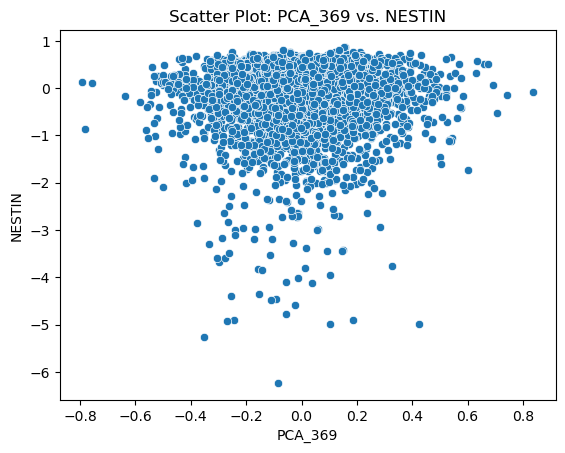

In [ ]:

# DataFrame conversion for PCA features
df_pca_tes = pd.DataFrame(X_pca, columns=[f'PCA_{i}' for i in range(X_pca.shape[1])])

# Load the target variable 'NESTIN' from your metadata
metadata = pd.read_csv('protein_expression_data.csv')
training_validation_specimens = ['A1', 'B1', 'D1']
metadata['specimen_id']=metadata.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
metadata = metadata[metadata['specimen_id'].isin(training_validation_specimens)]

y = metadata['NESTIN']

# Concatenate PCA features with the target variable into one DataFrame
df_final = pd.concat([df_pca_tes, y.rename('NESTIN')], axis=1)

# Calculate the correlation of each PCA feature with the target variable
correlations = df_final.corr()['NESTIN'].drop('NESTIN')

# Identify the PCA feature with the highest absolute correlation to 'NESTIN'
most_predictive_feature = correlations.abs().idxmax()
most_predictive_correlation = correlations.abs().max()

# Print the most predictive PCA feature and its correlation
print(f"The most predictive PCA feature is {most_predictive_feature} with a correlation of {most_predictive_correlation:.4f}.")

# Generate a scatter plot for the most predictive PCA feature against 'NESTIN'
sns.scatterplot(x=df_final[most_predictive_feature], y=df_final['NESTIN'])
plt.title(f'Scatter Plot: {most_predictive_feature} vs. NESTIN')
plt.xlabel(most_predictive_feature)
plt.ylabel('NESTIN')
plt.show()


Evaluating OLS Model

OLS Model Results:
RMSE: 0.591254035344544
Pearson Correlation Coefficient: 0.5512835140138674
Spearman Correlation Coefficient: 0.6338981003566562
R2 Score: 0.2019393794243195


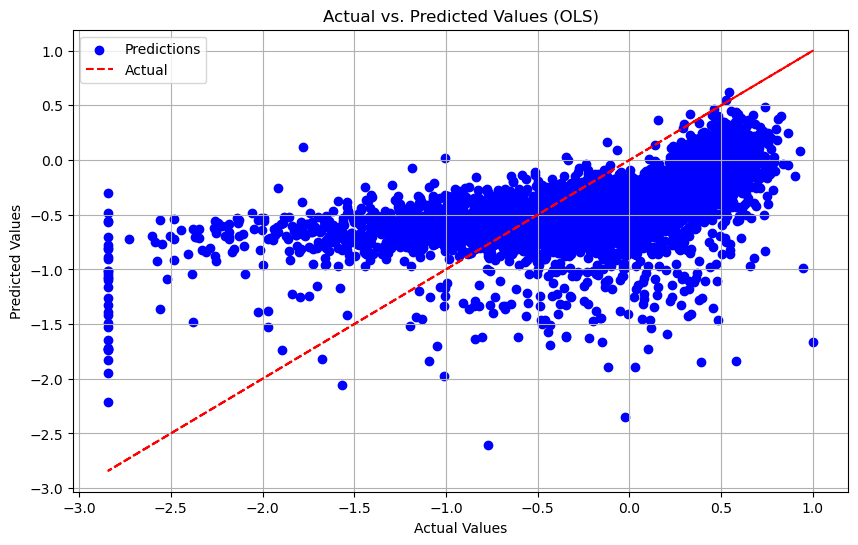


Evaluating SVR Model

SVR Model Results:
RMSE: 0.5930473583182198
Pearson Correlation Coefficient: 0.6051635630320863
Spearman Correlation Coefficient: 0.691197043791403
R2 Score: 0.19709086827812483


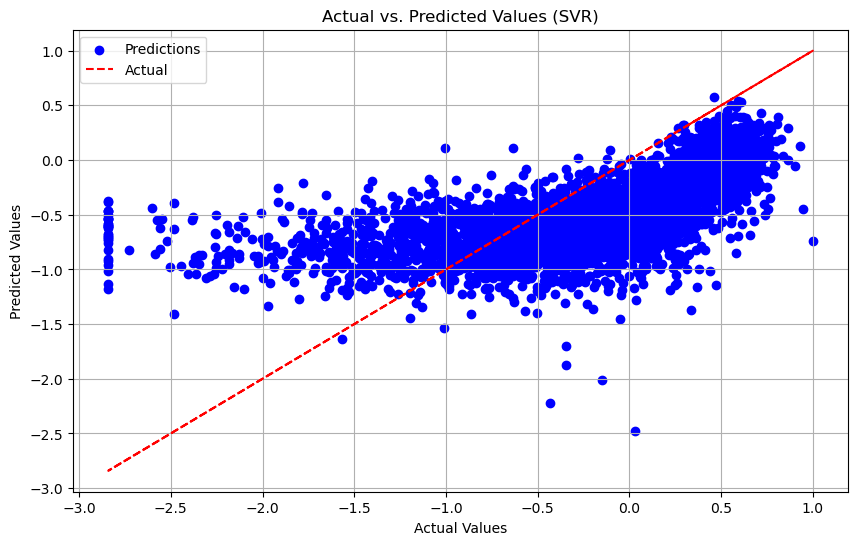

In [ ]:
model_performance = {}
# Function to read an image file and process it for feature extraction
def read_and_process_image(img_path, target_shape=(25, 25)):
    img = imread(img_path)
    if img.shape[-1] == 4:  # Convert RGBA to RGB
        img = rgba2rgb(img)
    img_resized = resize(img, target_shape, anti_aliasing=True)
    img_hed = rgb2hed(img_resized)
    features = np.concatenate([
        img_hed[:, :, 0].flatten(),
        img_resized[:, :, 2].flatten(),
        img_resized[:, :, 1].flatten(),
        img_resized[:, :, 0].flatten()
    ])
    return features
# Function to extract features from a list of images
def extract_features(image_ids, img_dir, target_shape=(25, 25)):
    features = [read_and_process_image(f"{img_dir}/{img_id}.png", target_shape) for img_id in image_ids]
    return np.array(features)

# Function to preprocess features using PCA for dimensionality reduction and scaling
def preprocess_features(X_train, X_test, n_components=0.95):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

# Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)

    return X_train_scaled, X_test_scaled

# Function to train a regression model and evaluate its performance
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    if model_type == 'OLS':
        X_train_const = sm.add_constant(X_train)
        model = sm.OLS(y_train, X_train_const).fit()
        X_test_const = sm.add_constant(X_test)
        predictions = model.predict(X_test_const)
    elif model_type == 'SVR':
        model = SVR(C=1.0, epsilon=0.2)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
    else:
        raise ValueError("Invalid model type. Choose 'OLS' or 'SVR'.")

# Calculate evaluation metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    pearson_corr, _ = pearsonr(y_test, predictions)
    spearman_corr, _ = spearmanr(y_test, predictions)
    r2 = r2_score(y_test, predictions)

     model_performance[model_type] = {
        'RMSE': rmse,
        'Pearson Correlation Coefficient': pearson_corr,
        'Spearman Correlation Coefficient': spearman_corr,
        'R2 Score': r2
    }

    print(f"\n{model_type} Model Results:")
    print(f"RMSE: {rmse}")
    print(f"Pearson Correlation Coefficient: {pearson_corr}")
    print(f"Spearman Correlation Coefficient: {spearman_corr}")
    print(f"R2 Score: {r2}")


# Create a scatter plot to visualize the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, color='blue', label='Predictions')
    plt.plot(y_test, y_test, color='red', linestyle='--', label='Actual')
    plt.title(f'Actual vs. Predicted Values ({model_type})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()



img_dir = 'patches_256/'  # Provide the path to the directory containing images
train_data = protein_ex[protein_ex['specimen_id'].isin(['A1', 'B1', 'D1'])]
test_data = protein_ex[protein_ex['specimen_id'].isin(['C1'])]

# Extract features from images
X_train = extract_features(train_data['image_id'].values, img_dir)
X_test = extract_features(test_data['image_id'].values, img_dir)

# Preprocess features (PCA and scaling)
X_train_scaled, X_test_scaled = preprocess_features(X_train, X_test)

# Train and evaluate using OLS model
print("Evaluating OLS Model")
train_and_evaluate(X_train_scaled, train_data['NESTIN'], X_test_scaled, test_data['NESTIN'], model_type='OLS')

# Train and evaluate using SVR model
print("\nEvaluating SVR Model")
train_and_evaluate(X_train_scaled, train_data['NESTIN'], X_test_scaled, test_data['NESTIN'], model_type='SVR')



In [ ]:
import glob


class CustomImageDataset(Dataset):
    def __init__(self, img_dir, df, transform=None, train=True):
        self.img_dir = img_dir
        self.transform = transform
        self.df = df
        self.train = train
        self.img_paths, self.labels = self._get_img_paths_and_labels()

    def _get_img_paths_and_labels(self):
        img_paths = []
        labels = []
        for filename in glob.glob(os.path.join(self.img_dir, '*.png')):
            img_id = os.path.basename(filename).split('.')[0]
            specimen_id = img_id.split('_')[0]
            if self.train and specimen_id in ['A1', 'B1', 'D1']:
                img_paths.append(filename)
                if img_id in self.df.index:
                    labels.append(self.df.loc[img_id, 'NESTIN'])  # Fetch the NESTIN label
                else:
                    labels.append(0)  # Default/fallback value
            elif not self.train and specimen_id == 'C1':
                img_paths.append(filename)
                if img_id in self.df.index:
                    labels.append(self.df.loc[img_id, 'NESTIN'])  # Fetch the NESTIN label
                else:
                    labels.append(0)  # Default/fallback value
        return img_paths, labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet standards
])

# Instantiate the dataset
train_dataset = CustomImageDataset(img_dir='patches_256/', df=protein_ex, transform=transform, train=True)
test_dataset = CustomImageDataset(img_dir='patches_256/', df=protein_ex, transform=transform, train=False)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:

class NESTINCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(NESTINCNN, self).__init__()
        # Load a pre-trained ResNet and modify it
        self.resnet = models.resnet50(pretrained=True)

        # Replace the classifier part of the ResNet with custom layers
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),  # Outputting a single value for regression
        )

    def forward(self, x):
        return self.resnet(x)

Epoch 1, Average Loss: 0.37874888655651046
Epoch 2, Average Loss: 0.2467004231899139
Epoch 3, Average Loss: 0.23365644969973698
Epoch 4, Average Loss: 0.22492775923935285
Epoch 5, Average Loss: 0.2179627047784357


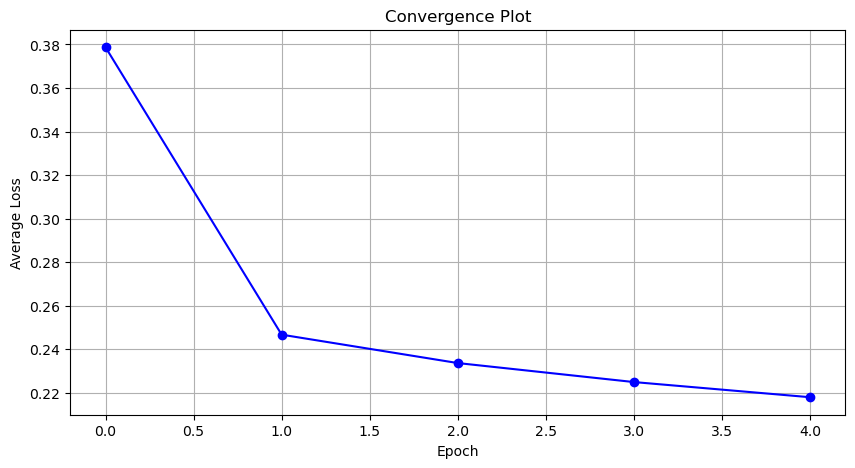

In [ ]:
# Load the training and test data using DataLoaders with specified batch sizes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set up the device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NESTINCNN().to(device)

# Set up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Initialize a list to store the average loss of each epoch
epoch_average_losses = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0  # Accumulator for the loss of the entire epoch
    num_batches = 0  # Counter for the total number of batches processed

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    epoch_average_losses.append(average_loss)
    print(f'Epoch {epoch+1}, Average Loss: {average_loss}')

# Plotting the convergence plot
plt.figure(figsize=(10, 5))
plt.plot(epoch_average_losses, marker='o', linestyle='-', color='blue')
plt.title('Convergence Plot')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

RMSE: 0.5714804530143738
Pearson Correlation Coefficient: 0.5456289215816199
Spearman Correlation Coefficient: 0.6480891326643923
R2 Score: 0.2428993914672768


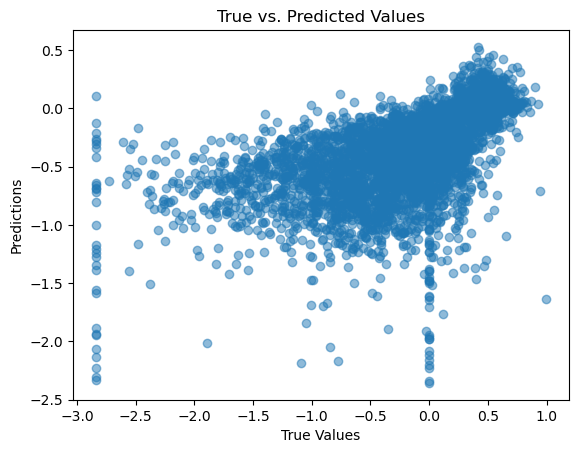

In [ ]:


model.eval()  # Set model to evaluation mode
predictions = []
true_values = []

with torch.no_grad():  # Inference without gradient calculation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_values.extend(labels.cpu().numpy())

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(true_values, predictions))
pearson_corr, _ = pearsonr(true_values, predictions)
spearman_corr, _ = spearmanr(true_values, predictions)
r2 = r2_score(true_values, predictions)

model_performance['CNN'] = {
    'RMSE': rmse,
    'Pearson Correlation Coefficient': pearson_corr,
    'Spearman Correlation Coefficient': spearman_corr,
    'R2 Score': r2
}

print(f"RMSE: {rmse}")
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")
print(f"R2 Score: {r2}")
import matplotlib.pyplot as plt

plt.scatter(true_values, predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

Epoch 1/3, Loss: 0.6133
Epoch 2/3, Loss: 0.0324
Epoch 3/3, Loss: 0.0315
RMSE: 0.455292284488678
Pearson Correlation: 0.14496482489124385
Spearman Correlation: 0.07440073369317106
R2 Score: -0.028151670946374052


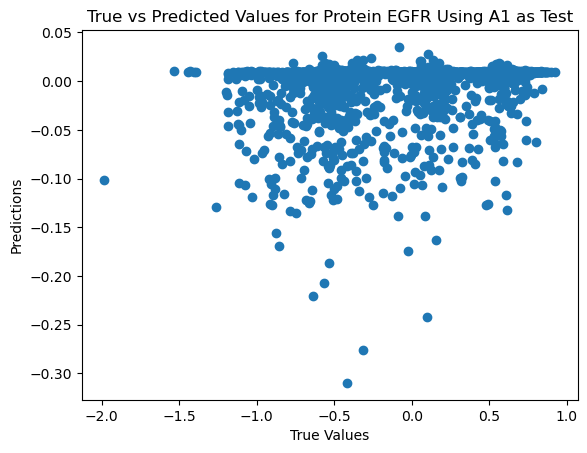

Epoch 1/3, Loss: 2.1399
Epoch 2/3, Loss: 0.8553
Epoch 3/3, Loss: 0.8234
RMSE: 0.9180697798728943
Pearson Correlation: 0.44802356759878376
Spearman Correlation: 0.18956819073177503
R2 Score: 0.16022614201900376


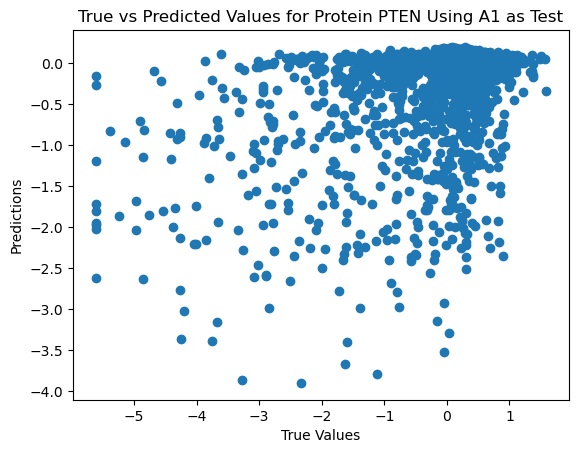

Epoch 1/3, Loss: 0.3643
Epoch 2/3, Loss: 0.2147
Epoch 3/3, Loss: 0.1928
RMSE: 0.6450083255767822
Pearson Correlation: 0.6561305964054259
Spearman Correlation: 0.7712925919244615
R2 Score: 0.3642697193289979


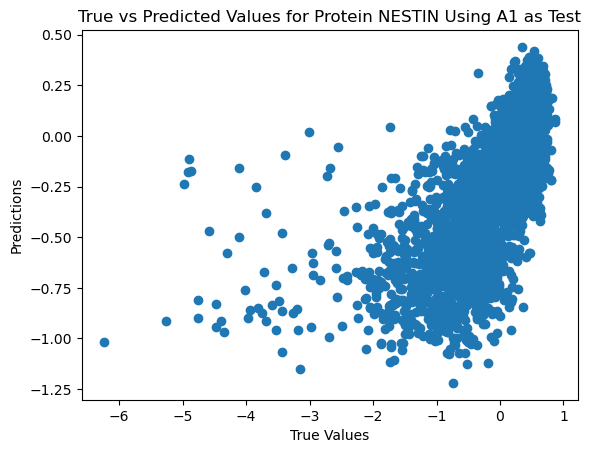

Epoch 1/3, Loss: 3.4471
Epoch 2/3, Loss: 0.5623
Epoch 3/3, Loss: 0.5400
RMSE: 1.085819959640503
Pearson Correlation: 0.465680994452922
Spearman Correlation: 0.6296457992801857
R2 Score: 0.19325810242773211


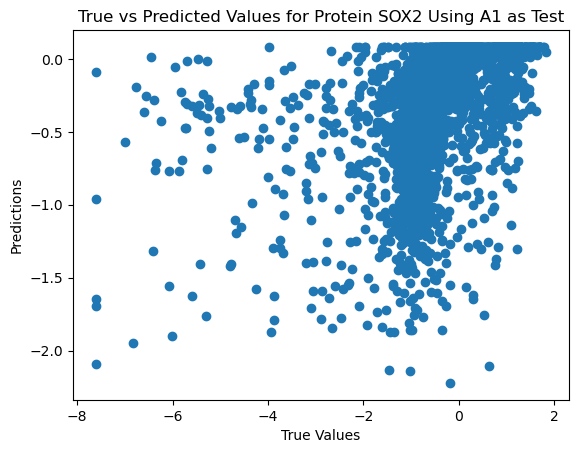

Epoch 1/3, Loss: 1.0374
Epoch 2/3, Loss: 0.9247
Epoch 3/3, Loss: 0.6732
RMSE: 0.6773975491523743
Pearson Correlation: 0.5051308079004178
Spearman Correlation: 0.3239253827169938
R2 Score: 0.25038507533082877


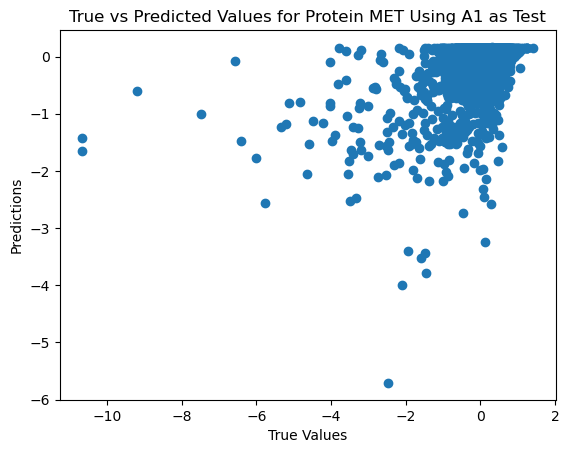

Epoch 1/3, Loss: 0.5849
Epoch 2/3, Loss: 0.0666
Epoch 3/3, Loss: 0.0614
RMSE: 0.2681646943092346
Pearson Correlation: -0.11775497508780639
Spearman Correlation: -0.12135948027372158
R2 Score: -0.44837777351002606


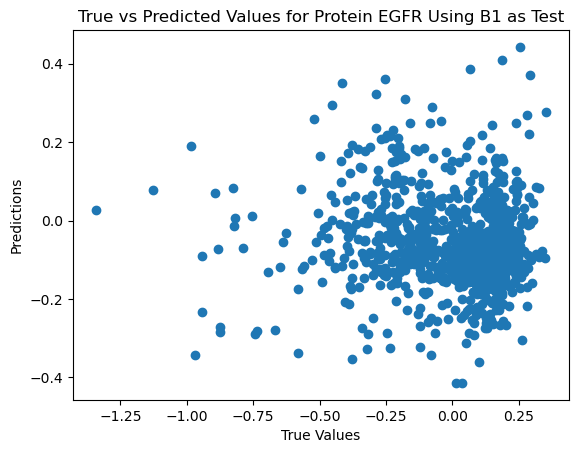

Epoch 1/3, Loss: 0.9803
Epoch 2/3, Loss: 0.7646
Epoch 3/3, Loss: 0.6948
RMSE: 0.8920566439628601
Pearson Correlation: 0.6768614269223767
Spearman Correlation: 0.27457195850858457
R2 Score: 0.4050277703576568


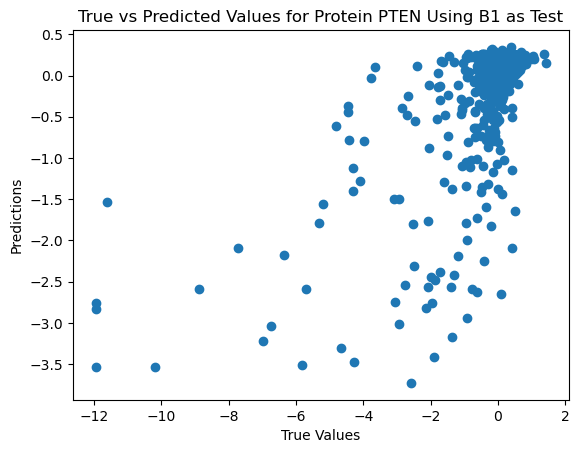

Epoch 1/3, Loss: 1.3350
Epoch 2/3, Loss: 0.2591
Epoch 3/3, Loss: 0.2529
RMSE: 0.5076093077659607
Pearson Correlation: 0.5972876358874677
Spearman Correlation: 0.44227485288209134
R2 Score: 0.12933197030844668


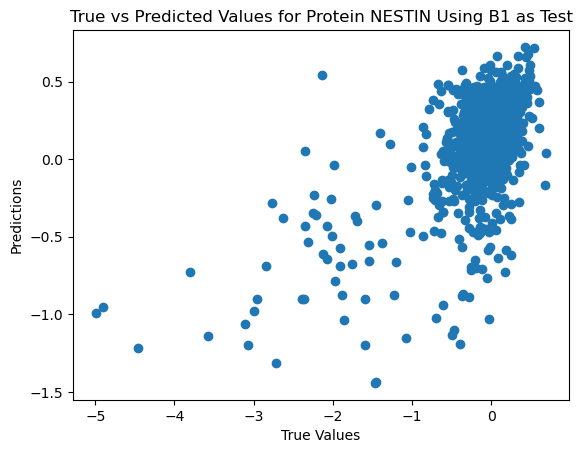

Epoch 1/3, Loss: 1.1424
Epoch 2/3, Loss: 0.7153
Epoch 3/3, Loss: 0.6659
RMSE: 0.9165897369384766
Pearson Correlation: -0.0389408404066792
Spearman Correlation: -0.1634334834556605
R2 Score: -0.38838005636410244


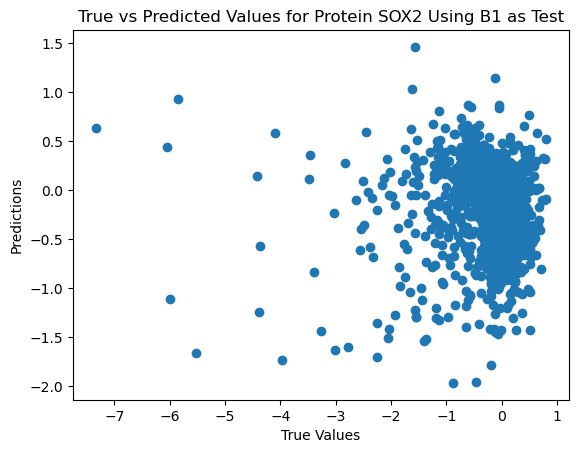

Epoch 1/3, Loss: 0.8545
Epoch 2/3, Loss: 0.6901
Epoch 3/3, Loss: 0.6013
RMSE: 0.7597196698188782
Pearson Correlation: 0.4887016544298972
Spearman Correlation: 0.08433265218971339
R2 Score: 0.21590594961292098


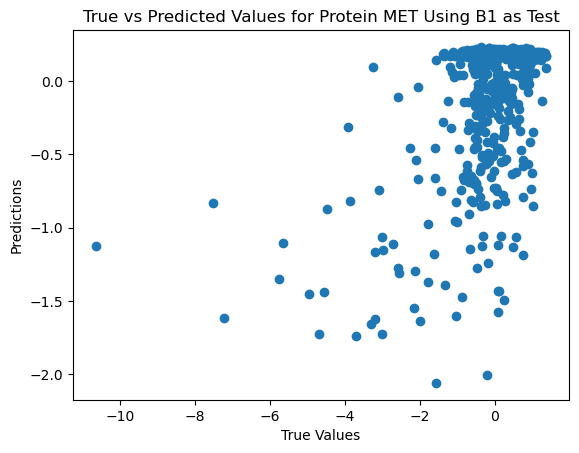

Epoch 1/3, Loss: 1.6037
Epoch 2/3, Loss: 0.0902
Epoch 3/3, Loss: 0.0797
RMSE: 0.21515796098928286
Pearson Correlation: 0.28416367061536635
Spearman Correlation: 0.4807425762624081
R2 Score: -0.41601971830443407


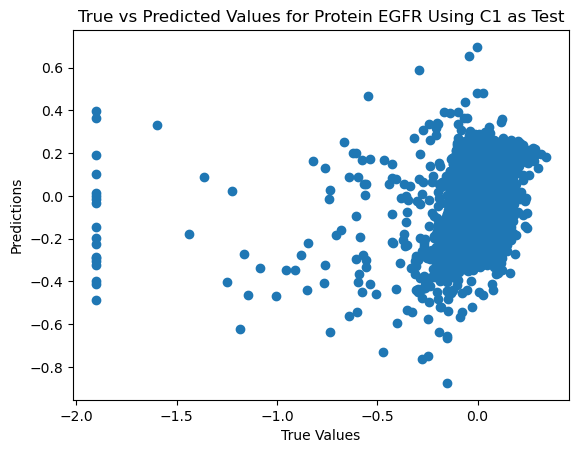

Epoch 1/3, Loss: 1.2074
Epoch 2/3, Loss: 0.6982
Epoch 3/3, Loss: 0.5140
RMSE: 1.052164644144164
Pearson Correlation: 0.590833514651101
Spearman Correlation: -0.01975450749633824
R2 Score: 0.17627268417326014


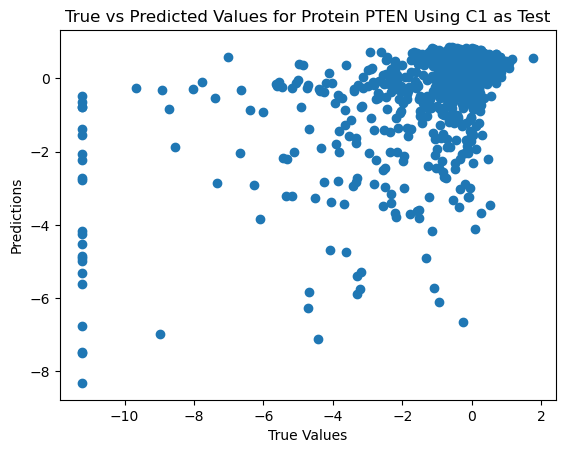

Epoch 1/3, Loss: 1.6004
Epoch 2/3, Loss: 0.3125
Epoch 3/3, Loss: 0.2702
RMSE: 0.6335885699217032
Pearson Correlation: 0.6707189814932182
Spearman Correlation: 0.7341516930169395
R2 Score: 0.08356366249648484


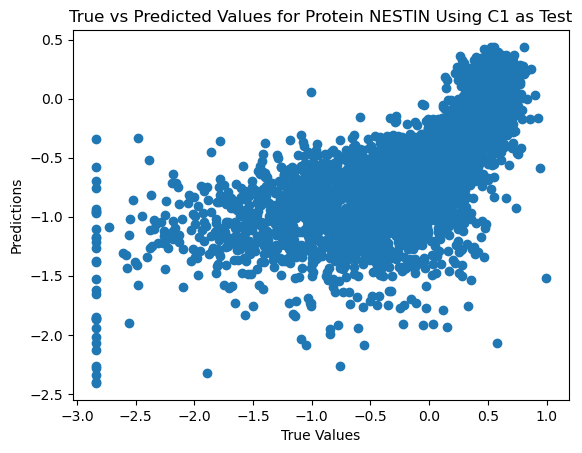

Epoch 1/3, Loss: 2.5866
Epoch 2/3, Loss: 0.7876
Epoch 3/3, Loss: 0.7540
RMSE: 0.7947485212917075
Pearson Correlation: 0.5661103558995355
Spearman Correlation: 0.6315043724162497
R2 Score: 0.31637182086183524


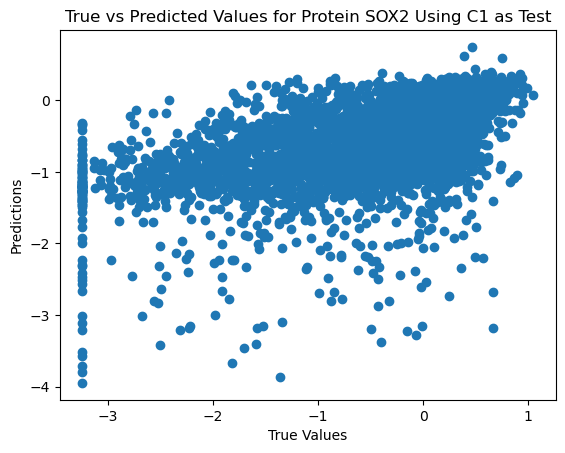

Epoch 1/3, Loss: 0.8788
Epoch 2/3, Loss: 0.4590
Epoch 3/3, Loss: 0.4242
RMSE: 0.9074631814734888
Pearson Correlation: 0.5458644950760376
Spearman Correlation: 0.14015365811779365
R2 Score: 0.29074104773504816


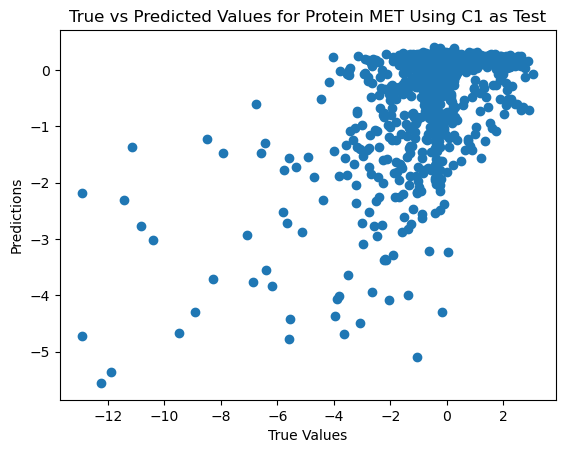

Epoch 1/3, Loss: 0.4078
Epoch 2/3, Loss: 0.0664
Epoch 3/3, Loss: 0.0557
RMSE: 0.2587336003780365
Pearson Correlation: 0.35459459656686354
Spearman Correlation: 0.3648945480693982
R2 Score: -0.4096548595959215


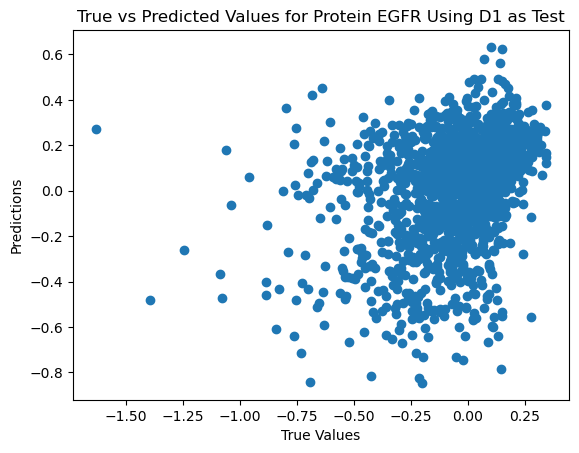

Epoch 1/3, Loss: 1.2614
Epoch 2/3, Loss: 0.8218
Epoch 3/3, Loss: 0.7676
RMSE: 1.233436942100525
Pearson Correlation: 0.6760164462663465
Spearman Correlation: 0.6368327170065337
R2 Score: 0.009976442680572961


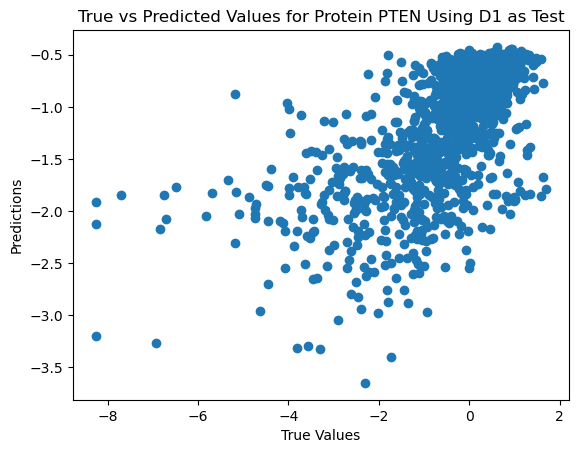

Epoch 1/3, Loss: 2.0194
Epoch 2/3, Loss: 0.3110
Epoch 3/3, Loss: 0.2886
RMSE: 0.49349331855773926
Pearson Correlation: 0.535075187332783
Spearman Correlation: 0.5493208236997035
R2 Score: -0.5647924533996238


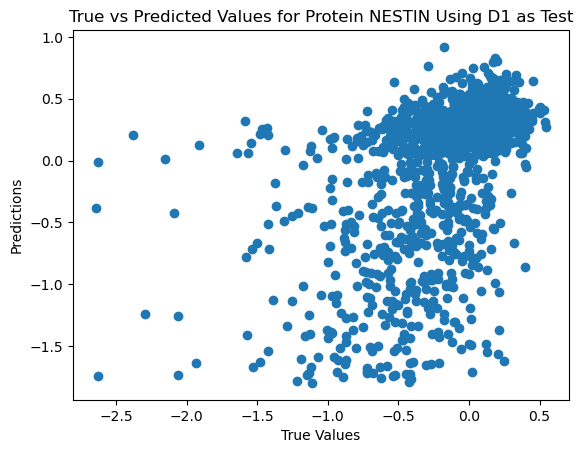

Epoch 1/3, Loss: 1.5116
Epoch 2/3, Loss: 0.7568
Epoch 3/3, Loss: 0.7344
RMSE: 0.8235722184181213
Pearson Correlation: 0.5197363390541128
Spearman Correlation: 0.4601715941976765
R2 Score: -0.05718456841758557


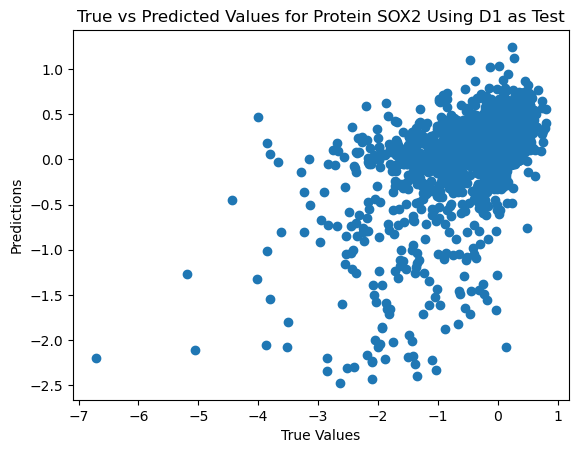

In [ ]:


proteins = ['EGFR', 'PTEN', 'NESTIN', 'SOX2', 'MET']


# Step 1: Custom Dataset class to load images and target values
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, image_column='image_id', target_column='NESTIN', transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.image_column = image_column
        self.target_column = target_column

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.loc[idx, self.image_column])
        image = Image.open(img_name + '.png')
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        image = image.resize((256, 256))
        target = torch.tensor(self.data_frame.loc[idx, self.target_column], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target

# Step 2: Define image transformations and create DataLoader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 3: Define neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(128 * 30 * 30, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 30 * 30)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 5: Train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs=3):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Step 6: Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            if isinstance(outputs, torch.Tensor):  # Check if outputs is a tensor
                outputs = outputs.squeeze()
                if len(outputs.shape) > 0:
                    all_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array
                else:
                    all_predictions.append(outputs.item())  # Append scalar value directly
            else:  # Handle single scalar output
                all_predictions.append(outputs)
            all_targets.extend(targets.cpu().numpy())  # Convert tensor to numpy array
    return all_predictions, all_targets

# Function to split data into train and test sets
def loocv(protein_ex):
    for specimen, group in protein_ex.groupby('Specimen'):
        train_df = protein_ex[protein_ex['Specimen'] != specimen]  # Training set
        train_df = train_df.reset_index(drop=True)
        test_df = group  # Test set
        test_df = test_df.reset_index(drop=True)

        train_df.to_csv('training_data_set.csv', index=False)
        test_df.to_csv('testing_data_set.csv', index=False)


        for protein in proteins:

            train_dataset = CustomDataset(csv_file='training_data_set.csv', root_dir='patches_256/', target_column=protein, transform=transform)
            test_dataset = CustomDataset(csv_file='testing_data_set.csv', root_dir='patches_256/', target_column=protein, transform=transform)

            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

            # Step 4: Instantiate the model, loss function, and optimizer
            model = Net()

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            train_model(model, criterion, optimizer, train_loader)

            predictions, targets = evaluate_model(model, test_loader)

            mse = mean_squared_error(targets, predictions)
            rmse = np.sqrt(mse)
            pearson_corr, _ = pearsonr(targets, predictions)
            spearman_corr, _ = spearmanr(targets, predictions)
            r2 = r2_score(targets, predictions)

             model_performance['loocv'] = {

                'RMSE': rmse,
                'Pearson Correlation': pearson_corr,
                'Spearman Correlation': spearman_corr,
                'R2 Score': r2
    }

            print(f"RMSE: {rmse}")
            print(f"Pearson Correlation: {pearson_corr}")
            print(f"Spearman Correlation: {spearman_corr}")
            print(f"R2 Score: {r2}")

            # Step 7: Plot scatter plot
            plt.scatter(targets, predictions)
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title('True vs Predicted Values' + ' for Protein ' + protein + ' Using ' + specimen + ' as Test')
            plt.show()



# Call the LOOCV function
loocv(protein_ex)

### Overall Performance Metrics

In [ ]:


# Creating a DataFrame from the performance metrics dictionary
performance_df = pd.DataFrame(model_performance).T

print(performance_df)

                   0     1     2
Model            OLS   SVR   CNN
RMSE            0.59  0.59  0.78
Pearson Corr.   0.55   0.6  0.46
Spearman Corr.  0.63  0.69  0.55
R2 Score         0.2  0.19  0.11
